In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import matplotlib

In [4]:
from sklearn.decomposition import PCA
import numpy as np

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [7]:
from sklearn.model_selection import cross_val_score

In [8]:
subset = ['Home',
 'teamPF_T6_x',
 'teamFT%_T6_x',
 'teamBLKR_T6_x',
 'teamPPS_T6_x',
 'teamEDiff_T6_x',
 'teamSTL/TO_T6_x',
 'teamTREB%_T6_y',
 'teamBLKR_T6_y',
 'teamPPS_T6_y',
 'teamAST/TO_T6_y',
 'teamSTL/TO_T6_y']

## Next test is to change the trailing averages of the original data and compare r2 results at different trailing amounts
#### From results above, I don't know which features will be more signficant if you increase/decrease trailing average so will use PCA on all components
##### therefore at each trailling average amount I will:
- Standardize X values
- Transform X Values with PCA at .95 level
- Predict target variable with components at different levels of alpha within Cross Validated Lasso Regression
- Record best result at best alpha
- visualize results

In [9]:
nba = pd.read_csv('2017-18_teamBoxScore.csv')
nba.head()

,PrimKey,opptKey,gmDate,teamAbbr,teamLoc,teamRslt,teamMin,teamDayOff,teamPTS,teamAST,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,43025BOS,43025CLE,10/17/2017,BOS,Away,Loss,241,0,99,24,...,55.5208,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,99.8648
1,43025CLE,43025BOS,10/17/2017,CLE,Home,Win,240,0,102,19,...,62.5519,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,100.2809
2,43025HOU,43025GS,10/17/2017,HOU,Away,Win,239,0,122,28,...,86.2033,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.9406
3,43025GS,43025HOU,10/17/2017,GS,Home,Loss,241,0,121,34,...,81.9038,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.0863
4,43026CHA,43026DET,10/18/2017,CHA,Away,Loss,238,0,90,16,...,70.7113,103.0506,90.9270,12.1236,0.4271,17.8731,2.6667,155.5556,98.9805,99.8123


In [10]:
#select columns that are numeric for trailing calc
nba_numbers = nba.select_dtypes(exclude='object')
a = pd.DataFrame(nba['PrimKey'])
nba_numbers = nba_numbers.merge(a,left_index=True, right_index=True)
nba_numbers.head()

,teamMin,teamDayOff,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,...,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace,PrimKey
0,241,0,99,24,12,11,4,24,88,36,...,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,99.8648,43025BOS
1,240,0,102,19,17,3,4,25,83,38,...,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,100.2809,43025CLE
2,239,0,122,28,13,9,5,16,97,47,...,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.9406,43025HOU
3,241,0,121,34,17,5,9,25,80,43,...,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.0863,43025GS
4,238,0,90,16,17,4,3,15,73,29,...,103.0506,90.9270,12.1236,0.4271,17.8731,2.6667,155.5556,98.9805,99.8123,43026CHA


In [11]:
num_fields = nba_numbers.columns.tolist()

In [12]:
#exclude fields that don't make sense to do a trailing average of
exclude = ['teamDayOff']
team_fields = [x for x in num_fields if x not in exclude]
#exclude opponent stats as it is redudant 
#as there is a line for the same game for the opponent too and 
#will merge that back later
team_fields = [x for x in team_fields if 'oppt' not in x]

In [13]:
#remove PrimKey
trailing_fields = [x for x in team_fields if x != 'PrimKey']

In [14]:
#get team names for loop below
teams = nba['teamAbbr'].unique()
len(teams) #correct should be 30

30

In [15]:
#create final set to merge with
#home/away, days off, and the dependent variable margin of victory

#dependent
nba['MarginOfVictory'] = nba['teamPTS'] - nba['opptPTS']
#dummy home
home = pd.get_dummies(nba['teamLoc'])
home = home['Home']
nba['Home'] = home
#final selection
nba_final = nba[['PrimKey','opptKey','MarginOfVictory','teamDayOff','Home']]
nba_final = nba_final.merge(nba[['PrimKey','teamDayOff']], left_on='opptKey', right_on='PrimKey')
nba_final.drop(columns='PrimKey_y', inplace=True)
nba_final.head()

,PrimKey_x,opptKey,MarginOfVictory,teamDayOff_x,Home,teamDayOff_y
0,43025BOS,43025CLE,-3,0,0,0
1,43025CLE,43025BOS,3,0,1,0
2,43025HOU,43025GS,1,0,0,0
3,43025GS,43025HOU,-1,0,1,0
4,43026CHA,43026DET,-12,0,0,0


In [16]:
#remove every other row
home = 0
away = 0
for i in range(0,2460,2):
    if home == away:
        nba_final.drop(i,0,inplace=True)
        away += 1
    elif home < away:
        nba_final.drop(i+1,0,inplace=True)
        home += 1
    elif home > away:
        nba_final.drop(i,0,inplace=True)
        away += 1  

In [17]:
nba_final.columns = nba_final.columns.str.replace('PrimKey_x', 'PrimKey')

In [18]:
nba_final.head()

,PrimKey,opptKey,MarginOfVictory,teamDayOff_x,Home,teamDayOff_y
1,43025CLE,43025BOS,3,0,1,0
2,43025HOU,43025GS,1,0,0,0
5,43026DET,43026CHA,12,0,1,0
6,43026BKN,43026IND,-9,0,0,0
9,43026ORL,43026MIA,7,0,1,0


In [19]:
nba_final.shape

(1230, 6)

In [38]:
trailing_fields.append('MarginOfVictory')

In [40]:
team_fields.append('MarginOfVictory')

In [60]:
def trailAvg(df, trailAmt, teams, team_fields, trailing_fields, df_final):

    #compute trailing average
    counter = 0
    for i in teams:
        temp = df[team_fields][df['teamAbbr']==i]
        for x in trailing_fields:
            temp[x+'_T6'] = temp[x].shift().rolling(window=trailAmt, min_periods = trailAmt).mean()
        if counter == 0:
            newDF = temp
        else:
            newDF = newDF.append(temp)
        counter = 1
        
    #create list with only trailing fields
    fields_t6 = [x for x in newDF.columns.tolist() if 'T6' in x]
    fields_t6.append('PrimKey')
    
    #left join/merge with final nba sample which has only unique games with MoV, Home/Away, Days 
    df_final = df_final.merge(newDF[fields_t6], how='left', left_on='PrimKey',right_on='PrimKey')
    df_final = df_final.merge(newDF[fields_t6], how='left', left_on='opptKey',right_on='PrimKey')
    
    #remove nas
    df_final.dropna(axis = 0, how='any', inplace=True)
    df_final.drop(columns='PrimKey_y', inplace=True)
    df_final.columns = df_final.columns.str.replace('PrimKey_x', 'PrimKey')
    nba_final.reset_index(inplace=True,drop=True)
    
    return df_final

In [21]:
#write function to standardize X values and PCA Transform
def scale_PCA(X):
    X1 = X.astype(float)
    scaler = StandardScaler()
    X_S = scaler.fit_transform(X1)
    pca1 = PCA(.95)
    pca1.fit(X_S)
    X_PCA = pca1.transform(X_S)
    return X_PCA

In [22]:
#function for regularization
def regularization(x, Y, model, alphaLst, Kfolds):
    results = []
    for i in alphaLst:
        Model = model(alpha=i)
        scores = cross_val_score(Model, x, Y,cv=Kfolds)
        sc = abs(scores.mean())
        #print("Alpha: %0.2f, Accuracy: %0.2f (+/- %0.2f)" % (i, scores.mean(), scores.std() * 2))
        results.append(sc)
    bestScore = max(results)
    #print()
    #print('Best Alpha: {}\nr2 of {:5.5f}'.format(alphaLst[results.index(bestScore)],bestScore))
    return alphaLst[results.index(bestScore)], bestScore

In [23]:
#write function to call scale_PCA for every iteration of trailing and regularization function to record best score

In [58]:
def trail_test(df, trailAmtLst, teams, team_fields, trailing_fields, df_final, alphaLst, model):
    bestScores = []
    bestAlphas = []
    for i in trailAmtLst:
        
        #print('TrailAmt: ',str(i))
        #create new trailing average subset
        new_trail_df = trailAvg(df, i, teams, team_fields, trailing_fields, df_final)
        
        #create list of X_columns
        X_Cols = []
        X_Cols.append('Home')
        X_Cols = [x for x in new_trail_df.columns.tolist() if '_x' in x or '_y' in x]

        #scale x data
        X_PCA = scale_PCA(new_trail_df[X_Cols])

        #get best lasso cross-validated score and alpha
        alpha, score = regularization(X_PCA, new_trail_df['MarginOfVictory'], model, alphaLst, 5)
        
        #append results to lists
        bestScores.append(score)
        bestAlphas.append(alpha)
        
    #bestScore = max(bestScores) # get best score
    
    #print('Best trailAmt: {}, Score: {}'.format(trailAmtLst[bestScores.index(bestScore)],bestScore)) #print it
    
    return trailAmtLst, bestAlphas, bestScores

In [25]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [26]:
trailLst = [x for x in range(6,30)]
aLst = [0.25,0.50,0.75,1.0]

In [54]:
trailAmtLst, bestAlphas, bestScores = trail_test(nba, trailLst, teams, team_fields, trailing_fields, nba_final, aLst, Lasso)

NameError: name 'mean' is not defined

In [64]:
def display_results(trailAmtLst, bestAlphas, bestScores, model, trailFunc):
    title = model + ' CV R2 for Different ' + trailFunc + ' Trailing Amounts'
    fig, ax = plt.subplots()
    ax.bar(trailAmtLst, bestScores)
    ax.set(xlabel='Trailing Amount',ylabel='5 fold CV Mean R2',title=title)
    plt.xticks(trailAmtLst)
    plt.show()
    s = 0
    
    for i in range(len(bestScores)):
        if bestScores[i] > s:
            s = bestScores[i]
            t = i
        print('Trail Amt: {}, r2 Score: {}, bestAlpha: {}'.format(trailAmtLst[i], round(bestScores[i],4), bestAlphas[i]))
    print()
    print('Best Score: {}, Trail Amt: {}'.format(round(s,4), trailAmtLst[t]))

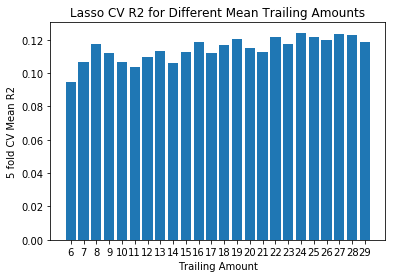

Trail Amt: 6, r2 Score: 0.0948, bestAlpha: 0.5
Trail Amt: 7, r2 Score: 0.1069, bestAlpha: 0.5
Trail Amt: 8, r2 Score: 0.1175, bestAlpha: 0.75
Trail Amt: 9, r2 Score: 0.1123, bestAlpha: 0.75
Trail Amt: 10, r2 Score: 0.1068, bestAlpha: 0.75
Trail Amt: 11, r2 Score: 0.1037, bestAlpha: 1.0
Trail Amt: 12, r2 Score: 0.1098, bestAlpha: 0.75
Trail Amt: 13, r2 Score: 0.1133, bestAlpha: 0.5
Trail Amt: 14, r2 Score: 0.1062, bestAlpha: 1.0
Trail Amt: 15, r2 Score: 0.1128, bestAlpha: 1.0
Trail Amt: 16, r2 Score: 0.1185, bestAlpha: 0.75
Trail Amt: 17, r2 Score: 0.112, bestAlpha: 0.5
Trail Amt: 18, r2 Score: 0.1167, bestAlpha: 0.5
Trail Amt: 19, r2 Score: 0.1207, bestAlpha: 0.5
Trail Amt: 20, r2 Score: 0.1151, bestAlpha: 0.5
Trail Amt: 21, r2 Score: 0.1125, bestAlpha: 0.5
Trail Amt: 22, r2 Score: 0.1217, bestAlpha: 0.5
Trail Amt: 23, r2 Score: 0.1175, bestAlpha: 0.75
Trail Amt: 24, r2 Score: 0.1242, bestAlpha: 0.25
Trail Amt: 25, r2 Score: 0.1215, bestAlpha: 0.25
Trail Amt: 26, r2 Score: 0.1198, best

In [66]:
display_results(trailAmtLst, bestAlphas, bestScores, 'Lasso', 'Mean')

In [80]:
trailAmtLst1, bestAlphas1, bestScores1 = trail_test(nba, trailLst, teams, team_fields, trailing_fields, nba_final, [500,1000,1500], Ridge)

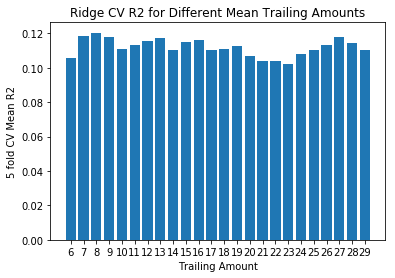

Trail Amt: 6, r2 Score: 0.1055, bestAlpha: 1000
Trail Amt: 7, r2 Score: 0.1187, bestAlpha: 1000
Trail Amt: 8, r2 Score: 0.1204, bestAlpha: 1000
Trail Amt: 9, r2 Score: 0.1179, bestAlpha: 1500
Trail Amt: 10, r2 Score: 0.1107, bestAlpha: 1500
Trail Amt: 11, r2 Score: 0.1132, bestAlpha: 1500
Trail Amt: 12, r2 Score: 0.1156, bestAlpha: 1500
Trail Amt: 13, r2 Score: 0.1174, bestAlpha: 1500
Trail Amt: 14, r2 Score: 0.1105, bestAlpha: 1500
Trail Amt: 15, r2 Score: 0.1151, bestAlpha: 1500
Trail Amt: 16, r2 Score: 0.1163, bestAlpha: 1500
Trail Amt: 17, r2 Score: 0.1102, bestAlpha: 1500
Trail Amt: 18, r2 Score: 0.111, bestAlpha: 1500
Trail Amt: 19, r2 Score: 0.1127, bestAlpha: 1000
Trail Amt: 20, r2 Score: 0.1069, bestAlpha: 1500
Trail Amt: 21, r2 Score: 0.1039, bestAlpha: 1000
Trail Amt: 22, r2 Score: 0.1037, bestAlpha: 1500
Trail Amt: 23, r2 Score: 0.1024, bestAlpha: 1500
Trail Amt: 24, r2 Score: 0.1078, bestAlpha: 1000
Trail Amt: 25, r2 Score: 0.1103, bestAlpha: 1000
Trail Amt: 26, r2 Score: 

In [81]:
display_results(trailAmtLst1, bestAlphas1, bestScores1, 'Ridge', 'Mean')

### do same as above with median

In [69]:
def trailAvg2(df, trailAmt, teams, team_fields, trailing_fields, df_final):

    #compute trailing average
    counter = 0
    for i in teams:
        temp = df[team_fields][df['teamAbbr']==i]
        for x in trailing_fields:
            temp[x+'_T6'] = temp[x].shift().rolling(window=trailAmt, min_periods = trailAmt).median()
        if counter == 0:
            newDF = temp
        else:
            newDF = newDF.append(temp)
        counter = 1
        
    #create list with only trailing fields
    fields_t6 = [x for x in newDF.columns.tolist() if 'T6' in x]
    fields_t6.append('PrimKey')
    
    #left join/merge with final nba sample which has only unique games with MoV, Home/Away, Days 
    df_final = df_final.merge(newDF[fields_t6], how='left', left_on='PrimKey',right_on='PrimKey')
    df_final = df_final.merge(newDF[fields_t6], how='left', left_on='opptKey',right_on='PrimKey')
    
    #remove nas
    df_final.dropna(axis = 0, how='any', inplace=True)
    df_final.drop(columns='PrimKey_y', inplace=True)
    df_final.columns = df_final.columns.str.replace('PrimKey_x', 'PrimKey')
    nba_final.reset_index(inplace=True,drop=True)
    
    return df_final

In [70]:
def trail_test2(df, trailAmtLst, teams, team_fields, trailing_fields, df_final, alphaLst, model):
    bestScores = []
    bestAlphas = []
    for i in trailAmtLst:
        
        #print('TrailAmt: ',str(i))
        #create new trailing average subset
        new_trail_df = trailAvg2(df, i, teams, team_fields, trailing_fields, df_final)
        
        #create list of X_columns
        X_Cols = []
        X_Cols.append('Home')
        X_Cols = [x for x in new_trail_df.columns.tolist() if '_x' in x or '_y' in x]

        #scale x data
        X_PCA = scale_PCA(new_trail_df[X_Cols])

        #get best lasso cross-validated score and alpha
        alpha, score = regularization(X_PCA, new_trail_df['MarginOfVictory'], model, alphaLst, 5)
        
        #append results to lists
        bestScores.append(score)
        bestAlphas.append(alpha)
        
    #bestScore = max(bestScores) # get best score
    
    #print('Best trailAmt: {}, Score: {}'.format(trailAmtLst[bestScores.index(bestScore)],bestScore)) #print it
    
    return trailAmtLst, bestAlphas, bestScores

In [71]:
trailAmtLst2, bestAlphas2, bestScores2 = trail_test2(nba, trailLst, teams, team_fields, trailing_fields, nba_final, aLst, Lasso)

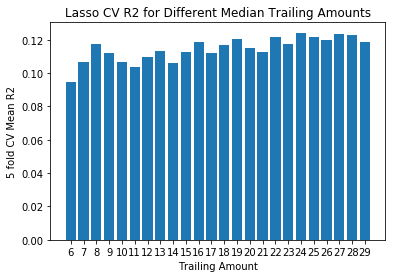

Trail Amt: 6, r2 Score: 0.0948, bestAlpha: 0.5
Trail Amt: 7, r2 Score: 0.1069, bestAlpha: 0.5
Trail Amt: 8, r2 Score: 0.1175, bestAlpha: 0.75
Trail Amt: 9, r2 Score: 0.1123, bestAlpha: 0.75
Trail Amt: 10, r2 Score: 0.1068, bestAlpha: 0.75
Trail Amt: 11, r2 Score: 0.1037, bestAlpha: 1.0
Trail Amt: 12, r2 Score: 0.1098, bestAlpha: 0.75
Trail Amt: 13, r2 Score: 0.1133, bestAlpha: 0.5
Trail Amt: 14, r2 Score: 0.1062, bestAlpha: 1.0
Trail Amt: 15, r2 Score: 0.1128, bestAlpha: 1.0
Trail Amt: 16, r2 Score: 0.1185, bestAlpha: 0.75
Trail Amt: 17, r2 Score: 0.112, bestAlpha: 0.5
Trail Amt: 18, r2 Score: 0.1167, bestAlpha: 0.5
Trail Amt: 19, r2 Score: 0.1207, bestAlpha: 0.5
Trail Amt: 20, r2 Score: 0.1151, bestAlpha: 0.5
Trail Amt: 21, r2 Score: 0.1125, bestAlpha: 0.5
Trail Amt: 22, r2 Score: 0.1217, bestAlpha: 0.5
Trail Amt: 23, r2 Score: 0.1175, bestAlpha: 0.75
Trail Amt: 24, r2 Score: 0.1242, bestAlpha: 0.25
Trail Amt: 25, r2 Score: 0.1215, bestAlpha: 0.25
Trail Amt: 26, r2 Score: 0.1198, best

In [72]:
display_results(trailAmtLst2, bestAlphas2, bestScores2, 'Lasso', 'Median')

In [78]:
trailAmtLst3, bestAlphas3, bestScores3 = trail_test2(nba, trailLst, teams, team_fields, trailing_fields, nba_final, [500,1000,1500], Ridge)

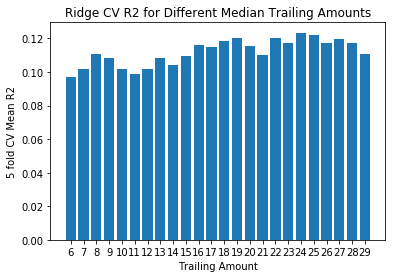

Trail Amt: 6, r2 Score: 0.0968, bestAlpha: 1000
Trail Amt: 7, r2 Score: 0.1017, bestAlpha: 1500
Trail Amt: 8, r2 Score: 0.1105, bestAlpha: 1500
Trail Amt: 9, r2 Score: 0.1085, bestAlpha: 1500
Trail Amt: 10, r2 Score: 0.1018, bestAlpha: 1500
Trail Amt: 11, r2 Score: 0.0987, bestAlpha: 1500
Trail Amt: 12, r2 Score: 0.1021, bestAlpha: 1500
Trail Amt: 13, r2 Score: 0.1083, bestAlpha: 1500
Trail Amt: 14, r2 Score: 0.1041, bestAlpha: 1500
Trail Amt: 15, r2 Score: 0.1097, bestAlpha: 1500
Trail Amt: 16, r2 Score: 0.1163, bestAlpha: 1000
Trail Amt: 17, r2 Score: 0.1149, bestAlpha: 1000
Trail Amt: 18, r2 Score: 0.1187, bestAlpha: 500
Trail Amt: 19, r2 Score: 0.1202, bestAlpha: 500
Trail Amt: 20, r2 Score: 0.1154, bestAlpha: 1000
Trail Amt: 21, r2 Score: 0.1104, bestAlpha: 1000
Trail Amt: 22, r2 Score: 0.1202, bestAlpha: 500
Trail Amt: 23, r2 Score: 0.1176, bestAlpha: 1000
Trail Amt: 24, r2 Score: 0.1234, bestAlpha: 500
Trail Amt: 25, r2 Score: 0.1223, bestAlpha: 500
Trail Amt: 26, r2 Score: 0.11

In [79]:
display_results(trailAmtLst3, bestAlphas3, bestScores3, 'Ridge', 'Median')

In [83]:
compare = pd.DataFrame()
compare['Trail_Amounts'] = trailAmtLst
compare['Lasso_TrailingMedian'] = bestScores2
compare['Ridge_TrailingMedian'] = bestScores3
compare['Lasso_TrailingMean'] = bestScores
compare['Ridge_TrailingMean'] = bestScores1

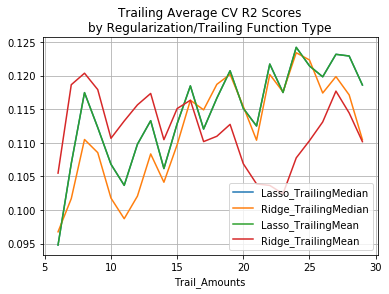

In [84]:
compare.plot(x='Trail_Amounts',kind='line', grid=True, title='Trailing Average CV R2 Scores\nby Regularization/Trailing Function Type')